In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *

import seaborn as sns
import scipy


In [4]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"

# EVENT = "FeedbackOnset"  # event in behavior to align on
# PRE_INTERVAL = 1300   # time in ms before event
# POST_INTERVAL = 1500  # time in ms after event
# INTERVAL_SIZE = 100  # size of interval in ms

OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

In [5]:
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")

In [6]:
pref_accs = []
pref_shuffle_accs = []
not_pref_accs = []
not_pref_shuffle_accs = []
for (feat1, feat2) in pairs.pair.values:
    name = f"high_conf_fixed_max_feat_by_pairs_{EVENT}_pair_{feat1}_{feat2}"  
    pref_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_test_accs.npy"))
    pref_accs.append(pref_acc)
    for i in range(5): 
        file_name = os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy")
        if os.path.isfile(file_name):
            shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy"))
            pref_shuffle_accs.append(shuffle_acc)
    
    name = f"high_conf_not_max_feat_by_pairs_{EVENT}_pair_{feat1}_{feat2}"  
    not_pref_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_test_accs.npy"))
    not_pref_accs.append(not_pref_acc)
    for i in range(5): 
        file_name = os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy")
        if os.path.isfile(file_name):
            shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy"))
            not_pref_shuffle_accs.append(shuffle_acc)
pref_accs = np.hstack(pref_accs)
pref_shuffle_accs = np.hstack(pref_shuffle_accs)
not_pref_accs = np.hstack(not_pref_accs)
not_pref_shuffle_accs = np.hstack(not_pref_shuffle_accs)

In [7]:
from scipy import stats

def assess_significance(data, shuffle, alpha):
    """
    T Test for when means of data is signficantly different from means of a shuffle
    assume data has shape [time bins, observations]
    Returns boolean of length timebins
    """
    sigs = np.full((data.shape[0]), False, dtype=bool)
    for i in range(data.shape[0]):
        res = stats.ttest_ind(data[i], shuffle[i], equal_var=False, alternative="greater")
        if res.pvalue < alpha:
            sigs[i] = True
    return sigs

In [10]:
times = np.arange(-(PRE_INTERVAL / 1000), POST_INTERVAL / 1000, INTERVAL_SIZE / 1000) + INTERVAL_SIZE / 1000
sigs_pref = assess_significance(pref_accs, pref_shuffle_accs, 0.05 / 20)
sigs_not_pref = assess_significance(not_pref_accs, not_pref_shuffle_accs, 0.05 / 20)
sig_pref_times = times[sigs_pref]
sigs_not_pref_times = times[sigs_not_pref]

Text(0, 0.5, 'Decoder Accuracy')

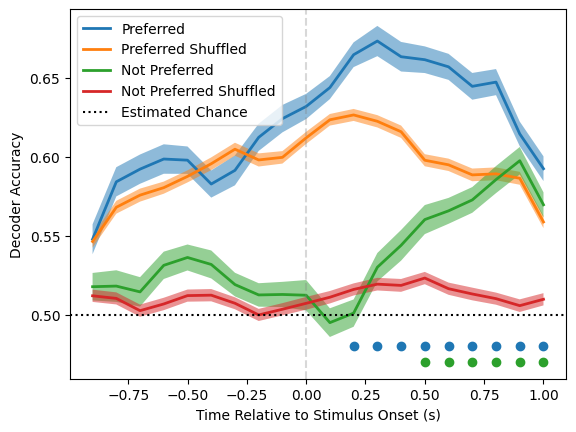

In [11]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    pref_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Preferred",
    right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    pref_shuffle_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Preferred Shuffled",
    right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_pref_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Not Preferred",
    right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_pref_shuffle_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Not Preferred Shuffled",
    right_align=True, 
    sem=True,
)
ax.scatter(sig_pref_times, np.ones(len(sig_pref_times)) * 0.48, color="tab:blue")
ax.scatter(sigs_not_pref_times, np.ones(len(sigs_not_pref_times)) * 0.47, color="tab:green")

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed')

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
# ax.set_ylim([0.5, 1])
ax.legend()
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")

### Try just using seaborn

In [12]:
def plot_seaborn(datas, labels, ax):
    dfs = []
    for i, data in enumerate(datas): 
        df = pd.DataFrame(data).reset_index(names=["Time"])
        df["Time"] = (df["Time"] * INTERVAL_SIZE + INTERVAL_SIZE - PRE_INTERVAL) / 1000
        df = df.melt(id_vars="Time", value_vars=list(range(data.shape[1])), var_name="run", value_name="Accuracy")
        df["label"] = labels[i]
        dfs.append(df)
    res = pd.concat(dfs)
    sns.lineplot(res, x="Time", y="Accuracy", hue="label", linewidth=2, ax=ax)

Text(0, 0.5, 'Decoder Accuracy')

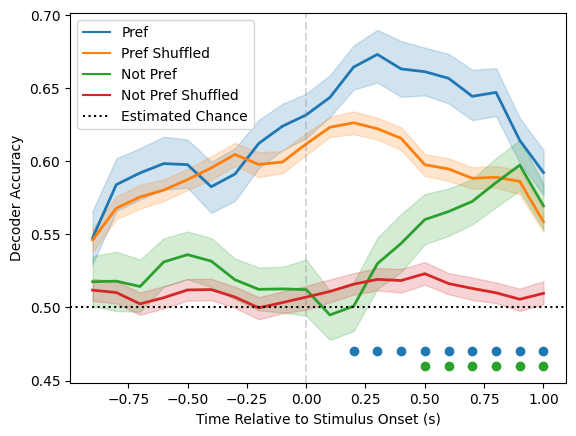

In [13]:
fig, ax = plt.subplots()
plot_seaborn([pref_accs, pref_shuffle_accs, not_pref_accs, not_pref_shuffle_accs], ["Pref", "Pref Shuffled", "Not Pref", "Not Pref Shuffled"], ax)
ax.scatter(sig_pref_times, np.ones(len(sig_pref_times)) * 0.47, color="tab:blue")
ax.scatter(sigs_not_pref_times, np.ones(len(sigs_not_pref_times)) * 0.46, color="tab:green")

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed')

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
# ax.set_ylim([0.5, 1])
ax.legend()
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")

### Conclusion: 
- Decoding between pairs of preferred and chosen features, in high confidence trials. 
- Want to compare to decoding the features when features are chosen but not preferred. 
- Observe higher decoding accuacy of preferred features, earlier in search period. 
- plotting SEM in pyplot, 95 CI in seaborn plot
- significance assessed with Welch's TTest, p <= 0.05 (bonferroni corrected across 20 time bins)
